In [1]:
import obspy
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import util
from scipy.fft import fft, ifft, fftfreq, rfft
import pickle
from obspy import UTCDateTime
import scipy.signal as signal
from spectrum import *
from pylab import *
import pandas as pd

In [2]:
root = '/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3/'

In [4]:
eq_list = os.listdir(root)

client = Client("IRIS")

cat = obspy.read_events('/home/earthquakes1/homes/Rebecca/phd/data/2019_global_m3_catalog.xml')

eq_with_data = []
cat_with_data = cat.copy()
cat_with_data.clear()
for event in cat:
    eq_name = util.catEventToFileName(event)
    if os.path.isdir(root+eq_name) and os.path.isdir(root+eq_name+'/station_xml_files') and os.path.exists(root+eq_name+'/picks.pkl'):
        eq_with_data.append(eq_name)
        cat_with_data.extend([event])

In [5]:
binned_spectra = [
    [[],[],[],[]],#0-1
    [[],[],[],[]],#1-2
    [[],[],[],[]],#2-3
    [[],[],[],[]],#3-4
    [[],[],[],[]],#4-5
    [[],[],[],[]],#5-6
    [[],[],[],[]],#6-7
    [[],[],[],[]],#7-8
    [[],[],[],[]]#8-9
]

In [ ]:
%%script false --no-raise-error
cmap = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
fig, axs = plt.subplots(1,1)
failed = []
for eq_no in range(0, len(eq_with_data[0:100])):
    eq_name = eq_with_data[eq_no]
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        #data.plot()
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
    except: 
        break
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            try:
                sr = data[tr_no].stats.sampling_rate
                tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
                #print(tr_name)
                pick = UTCDateTime(picks[tr_name])
                start = pick #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 4 # int(start + 4 * sr)
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                coda = d.trim(start, end)
                coda.detrend()
                #plt.plot(coda)
                good = 'y'# input()
                if good.lower()[0]=='y':
                    dt = d.stats.delta

                    #creating the frequencies to plot on x axis 
                    Pfreq  = scipy.fft.rfftfreq(len(coda),dt)

                    #doing the multitaper to get the spectra 
                    N = len(coda)
                    NW=0.01*N
                    k=25
                    [tapers, eigen] = dpss(N, NW, k)
                    for eigen_no in range(0, len(eigen)):
                        if eigen[eigen_no] <= 0.5:
                            k = eigen_no
                            break
                    [tapers, eigen] = dpss(N, NW, k)

                    #print(eigen)
                    freq_complex, weights, eigenvalues=pmtm(coda, e=eigen, v=tapers, show=False)
                    freq = abs(freq_complex)
                    freq = np.mean(freq,axis =0)
                    freq_sdv = np.std(freq,axis =0)

                    dist = util.calc_hypo_dist(cat_with_data[eq_no], d, inv)
                    mag = cat_with_data[eq_no].magnitudes[0].mag
                    binned_spectra[int(np.round(mag, 0))][int(dist//50)].append([Pfreq[:-1],freq[0:N//2]])

                    #plotting the spectra in loglog
                    #print('plot')
                    if successful == 0:
                        axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), alpha = 0.5, label=str(cat_with_data[eq_no].magnitudes[0].mag), color = cmap[eq_no])#tr_name + data[tr_no].stats.channel)
                    #plt.fill_between(Pfreq[:-1],(Sk+Sk_sdv)[0:N//2],(Sk-Sk_sdv)[0:N//2],alpha=0.2)
                        axs.set_xlabel('Frequency (Hz)');
                        axs.set_ylabel('A^2');
                    #plt.title(tr_name + data[tr_no].stats.channel+' coda wave Power spectra');
                    #else:
                        #axs.plot(Pfreq[:-1],freq[0:N//2]-min(freq[0:N//2]), color = cmap[eq_no], alpha = 0.5)#tr_name + data[tr_no].stats.channel)

                    Pfreq_MHZ = Pfreq
                    freq_MHZ = freq 
                    successful += 1
                else:
                    failed.append([eq_name, tr_name])
            #print(freq_MHZ.shape)
            #plt.show()
            except:
                failed.append([eq_name, tr_name])
axs.legend();
#axs.set_title('M'+str(cat_with_data[eq_no].magnitudes[0].mag) + ' ' + eq_name)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(0.5, 50)
#plt.close()


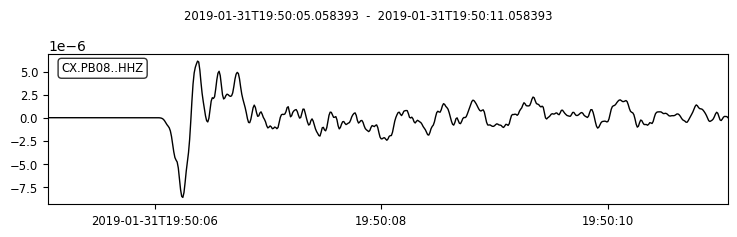

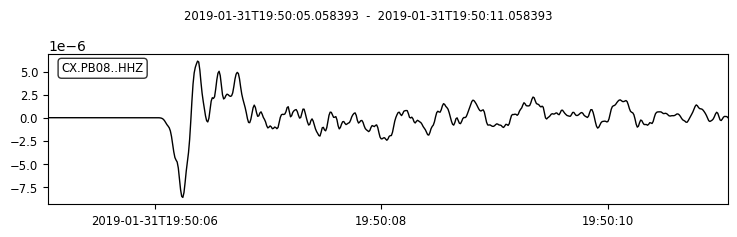

In [11]:
d.plot()

TypeError: cannot unpack non-iterable Axes object

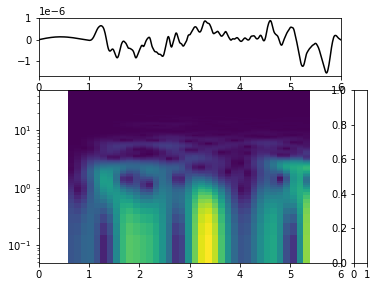

In [112]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

#make time vector
t = np.arange(d.stats.npts) / d.stats.sampling_rate

#plot waveform (top subfigure)    
ax1.plot(t, d.data, 'k')

#plot spectrogram (bottom subfigure)
spl2 = d
f, t, Sxx = spl2.spectrogram(show=False, axes=ax2, log = True)
mappable = ax2.collections[0]
ax2.vlines(1, 0, 50, color='white')
ax2.vlines(5, 0, 50, color='white')
ax2.hlines(1/tpmax, 0, 6, color='hotpink')
ax2.hlines(1/tc, 0, 6, color='skyblue')
plt.colorbar(mappable=mappable, cax=ax3)

TypeError: float() argument must be a string or a number, not 'QuadMesh'

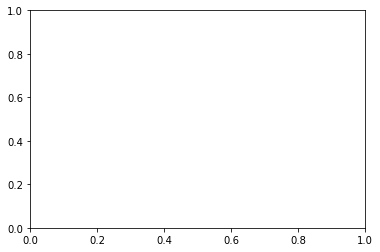

In [111]:
plt.plot(fig.collections[0])

In [6]:
df =  pd.read_pickle('/home/earthquakes1/homes/Rebecca/phd/seismo_det/dataframe_bandpass_3_0_075Hz.pkl')

# actual spectrograms

20190131_194949.a


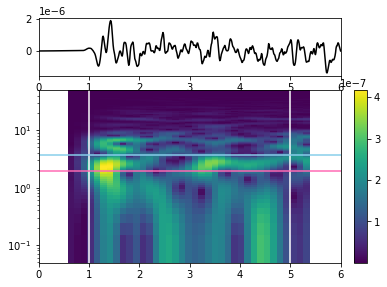

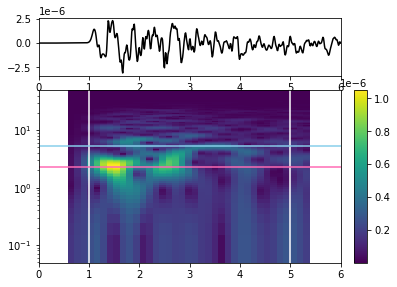

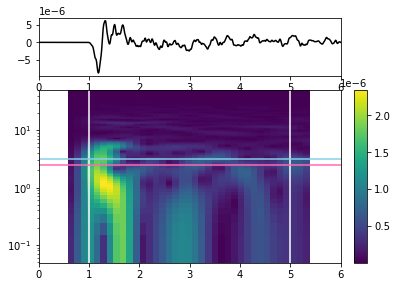

In [9]:
import random 
from datetime import timedelta
for count in range(0, 1):#len(eq_with_data[0:100])):
    eq_no = count # random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    #try:
    data = obspy.read(root+eq_name+'/data/*/*')
    #data.plot()
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    data.remove_response(inv)
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    df_row = df.loc[eq_name]
    #except: 
        #continue
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            #print(tr_name)
            # only consider vertical stations (Z)
            if data[tr_no].stats.channel[-1] == 'Z':
                #try:
                tpmax = df_row.tpmax[Z_comp]
                tc = df_row.tc[Z_comp]

                t = util.filenameToDate(eq_name)
                filter_start = str(UTCDateTime(t-timedelta(seconds=1)))
                filter_stop = str(UTCDateTime(t+timedelta(seconds=1)))

                event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
                # print(event)
                data_nearby = util.find_nearby_data(data, inv, event[0], 100)
                #print('pick')
                pick = UTCDateTime(picks[tr_name])
                start = pick -1 #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 5 # int(start + 4 * sr)
                #print('d')
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                d.trim(start, end)
                d.detrend()
                #print('plotting')
                from obspy.imaging.spectrogram import spectrogram
                fig = plt.figure()
                ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                #make time vector
                t = np.arange(d.stats.npts) / d.stats.sampling_rate

                #plot waveform (top subfigure)    
                ax1.plot(t, d.data, 'k')

                #plot spectrogram (bottom subfigure)
                spl2 = d
                fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                mappable = ax2.collections[0]
                ax2.vlines(1, 0, 50, color='white')
                ax2.vlines(5, 0, 50, color='white')
                ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                ax2.hlines(1/tc, 0, 6, color='skyblue')
                plt.colorbar(mappable=mappable, cax=ax3)
                plt.savefig('/home/earthquakes1/homes/Rebecca/phd/data/spectrograms/'+eq_name+'_'+tr_name+'.png')
                Z_comp += 1
                #except:
                #    continue #print('except')
                

# trying to get the data out of one spectrogram
## load one eq of data

In [28]:
for count in range(0, 1):#len(eq_with_data[0:100])):
    eq_no = count # random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    #try:
    data = obspy.read(root+eq_name+'/data/*/*')
    #data.plot()
    inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
    data.remove_response(inv)
    with open(root+eq_name+'/picks.pkl', 'rb') as f:
        picks = pickle.load(f)
    df_row = df.loc[eq_name]
    #except: 
        #continue
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            #print(tr_name)
            # only consider vertical stations (Z)
            if data[tr_no].stats.channel[-1] == 'Z':
                #try:
                tpmax = df_row.tpmax[Z_comp]
                tc = df_row.tc[Z_comp]

                t = util.filenameToDate(eq_name)
                filter_start = str(UTCDateTime(t-timedelta(seconds=1)))
                filter_stop = str(UTCDateTime(t+timedelta(seconds=1)))

                event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
                # print(event)
                data_nearby = util.find_nearby_data(data, inv, event[0], 100)
                #print('pick')
                pick = UTCDateTime(picks[tr_name])
                start = pick -1 #int((pick - data[tr_no].stats.starttime)*sr)
                end = pick + 5 # int(start + 4 * sr)
                #print('d')
                d = data[tr_no].copy()#.filter('lowpass', freq=10)
                d.interpolate(100, 'lanczos', a = 20)
                d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                d.detrend()
                d.integrate()
                d.detrend()
                d.trim(start, end)
                d.detrend()
                #print('plotting')
                '''from obspy.imaging.spectrogram import spectrogram
                fig = plt.figure()
                ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                #make time vector
                t = np.arange(d.stats.npts) / d.stats.sampling_rate

                #plot waveform (top subfigure)    
                ax1.plot(t, d.data, 'k')

                #plot spectrogram (bottom subfigure)
                spl2 = d
                fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                mappable = ax2.collections[0]
                ax2.vlines(1, 0, 50, color='white')
                ax2.vlines(5, 0, 50, color='white')
                ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                ax2.hlines(1/tc, 0, 6, color='skyblue')
                plt.colorbar(mappable=mappable, cax=ax3)'''



20190131_194949.a


## make spectrogram using matplotlib?

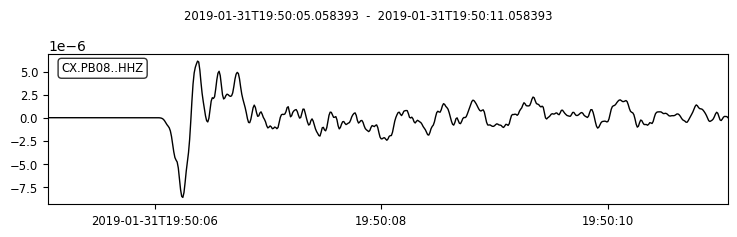

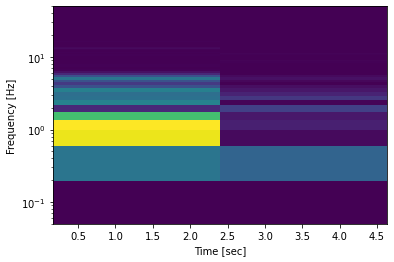

In [31]:
d.plot()                
f, t, Sxx = signal.spectrogram(d.data, 100)
plt.figure()
plt.pcolormesh(t, f, Sxx, shading='nearest')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim([0.05,50])
plt.show()

 that was a mistake

## return to using obspy

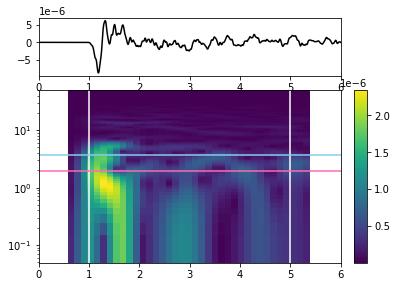

In [21]:
                fig = plt.figure()
                ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2]) #[left bottom width height]
                ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
                ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

                #make time vector
                t = np.arange(d.stats.npts) / d.stats.sampling_rate

                #plot waveform (top subfigure)    
                ax1.plot(t, d.data, 'k')

                #plot spectrogram (bottom subfigure)
                spl2 = d
                fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                mappable = ax2.collections[0]
                ax2.vlines(1, 0, 50, color='white')
                ax2.vlines(5, 0, 50, color='white')
                ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                ax2.hlines(1/tc, 0, 6, color='skyblue')
                plt.colorbar(mappable=mappable, cax=ax3)

the ax2 data is key here -- work out what i can look at from it

In [41]:
ax2.__dict__

{'_stale': True,
 'stale_callback': <function matplotlib.figure._stale_figure_callback(self, val)>,
 '_axes': <Axes:>,
 'figure': <Figure size 432x288 with 3 Axes>,
 '_transform': None,
 '_transformSet': False,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': None,
 '_clippath': None,
 '_clipon': True,
 '_label': '',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x7fa89e6dc640>,
 '_remove_method': <bound method FigureBase.delaxes of <Figure size 432x288 with 3 Axes>>,
 '_url': None,
 '_gid': None,
 '_snap': None,
 '_sketch': None,
 '_path_effects': [],
 '_sticky_edges': _XYPair(x=[], y=[]),
 '_in_layout': True,
 '_position': Bbox([[0.1, 0.1], [0.7999999999999999, 0.7]]),
 '_originalPosition': Bbox([[0.1, 0.1], [0.7999999999999999, 0.7]]),
 '_aspect': 'auto',
 '_adjustable': 'box',
 '_anchor': 'C',
 '_stale_viewlim_x': False,
 '_stale_viewlim_y': False,
 '_

lets name l the ax2.collections option

In [126]:

l = ax2.collections


l[0] is a quadbox or something. what can we find out about that?

In [54]:
l[0].__dict__

{'_stale': False,
 'stale_callback': <function matplotlib.artist._stale_axes_callback(self, val)>,
 '_axes': <Axes:>,
 'figure': <Figure size 432x288 with 3 Axes>,
 '_transform': <matplotlib.transforms.CompositeGenericTransform at 0x7fa89e6dce20>,
 '_transformSet': True,
 '_visible': True,
 '_animated': False,
 '_alpha': None,
 'clipbox': <matplotlib.transforms.TransformedBbox at 0x7fa89e6b4340>,
 '_clippath': None,
 '_clipon': True,
 '_label': '_collection0',
 '_picker': None,
 '_contains': None,
 '_rasterized': False,
 '_agg_filter': None,
 '_mouseover': False,
 '_callbacks': <matplotlib.cbook.CallbackRegistry at 0x7fa89e6f1a30>,
 '_remove_method': <function list.remove(value, /)>,
 '_url': None,
 '_gid': None,
 '_snap': True,
 '_sketch': None,
 '_path_effects': None,
 '_sticky_edges': _XYPair(x=[0.57499999999999996, 5.3849999999999998], y=[0.048828125, 50.048828125]),
 '_in_layout': True,
 '_A': masked_array(data = [  2.64301099e-07   6.67474257e-07   1.06554076e-06 ...,   1.5994099

has an amplitude value! 

In [68]:
len(l[0]._A)

18944

and a coordinates option which gives the positions of the corners of the boxes

In [61]:
l[0]._coordinates.shape

(513, 38, 2)

In [84]:
coords = l[0]._coordinates
amp = l[0]._A

In [79]:
len(amp)

18944

we need to ignore the last row and column of coords so that we only consider the lower left corner and put out points there.
that way we have the same number of coordinates and amplitude values

In [92]:
coords_concat = np.array(coords[0][:-1])
for i in range(1, len(coords)-1):
    coords_concat = np.concatenate((coords_concat, coords[i][:-1]))

In [93]:
coords_concat

array([[  5.75000000e-01,   4.88281250e-02],
       [  7.05000000e-01,   4.88281250e-02],
       [  8.35000000e-01,   4.88281250e-02],
       ..., 
       [  4.99500000e+00,   4.99511719e+01],
       [  5.12500000e+00,   4.99511719e+01],
       [  5.25500000e+00,   4.99511719e+01]])

transfer into y and x for plotting

In [107]:
y = []
x = []
for j in coords_concat:
    y.append(j[1])
    x.append(j[0])

each row has 37 values in it

In [112]:
for j in range(0, len(coords_concat), 37):
    print(j, coords_concat[j][0])

0 0.575
37 0.575
74 0.575
111 0.575
148 0.575
185 0.575
222 0.575
259 0.575
296 0.575
333 0.575
370 0.575
407 0.575
444 0.575
481 0.575
518 0.575
555 0.575
592 0.575
629 0.575
666 0.575
703 0.575
740 0.575
777 0.575
814 0.575
851 0.575
888 0.575
925 0.575
962 0.575
999 0.575
1036 0.575
1073 0.575
1110 0.575
1147 0.575
1184 0.575
1221 0.575
1258 0.575
1295 0.575
1332 0.575
1369 0.575
1406 0.575
1443 0.575
1480 0.575
1517 0.575
1554 0.575
1591 0.575
1628 0.575
1665 0.575
1702 0.575
1739 0.575
1776 0.575
1813 0.575
1850 0.575
1887 0.575
1924 0.575
1961 0.575
1998 0.575
2035 0.575
2072 0.575
2109 0.575
2146 0.575
2183 0.575
2220 0.575
2257 0.575
2294 0.575
2331 0.575
2368 0.575
2405 0.575
2442 0.575
2479 0.575
2516 0.575
2553 0.575
2590 0.575
2627 0.575
2664 0.575
2701 0.575
2738 0.575
2775 0.575
2812 0.575
2849 0.575
2886 0.575
2923 0.575
2960 0.575
2997 0.575
3034 0.575
3071 0.575
3108 0.575
3145 0.575
3182 0.575
3219 0.575
3256 0.575
3293 0.575
3330 0.575
3367 0.575
3404 0.575
3441 0.57

now can plot as a scatter graph, colored by amplitude and get basically the same result! 

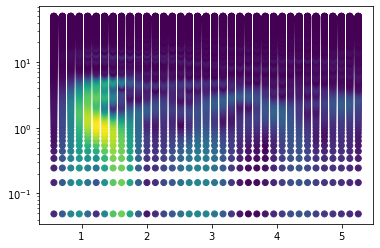

In [121]:
plt.scatter(x,y, c = amp, cmap='viridis')
plt.yscale('log')
#plt.xlim([0.5,1])
#plt.ylim([0,1])

# now onto the actual exercise

we want to sum the columns to work out something which is basically the power

so need to swtich from thinking about rows to columns

In [227]:
columns_x = [[] for _ in range(37)]
columns_y = [[] for _ in range(37)]
columns_amp = [[] for _ in range(37)]

In [223]:
x

[0.57499999999999996,
 0.70500000000000007,
 0.83499999999999996,
 0.96500000000000008,
 1.095,
 1.2250000000000001,
 1.355,
 1.4850000000000001,
 1.615,
 1.7450000000000001,
 1.875,
 2.0049999999999999,
 2.1350000000000002,
 2.2650000000000001,
 2.395,
 2.5249999999999999,
 2.6550000000000002,
 2.7850000000000001,
 2.915,
 3.0449999999999999,
 3.1750000000000003,
 3.3050000000000002,
 3.4350000000000001,
 3.5649999999999999,
 3.6949999999999998,
 3.8250000000000002,
 3.9549999999999996,
 4.085,
 4.2149999999999999,
 4.3449999999999998,
 4.4749999999999996,
 4.6049999999999995,
 4.7349999999999994,
 4.8649999999999993,
 4.9949999999999992,
 5.125,
 5.2549999999999999,
 0.57499999999999996,
 0.70500000000000007,
 0.83499999999999996,
 0.96500000000000008,
 1.095,
 1.2250000000000001,
 1.355,
 1.4850000000000001,
 1.615,
 1.7450000000000001,
 1.875,
 2.0049999999999999,
 2.1350000000000002,
 2.2650000000000001,
 2.395,
 2.5249999999999999,
 2.6550000000000002,
 2.7850000000000001,
 2.915

In [228]:
for i in range(0, len(coords_concat)):
    print(i)
    columns_x[i%37].append(x[i])
    columns_y[i%37].append(y[i])
    columns_amp[i%37].append(amp[i])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641


4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165


7513
7514
7515
7516
7517
7518
7519
7520
7521
7522
7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536
7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548
7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562
7563
7564
7565
7566
7567
7568
7569
7570
7571
7572
7573
7574
7575
7576
7577
7578
7579
7580
7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712


9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051
10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
100

12360
12361
12362
12363
12364
12365
12366
12367
12368
12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380
12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395
12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408
12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419
12420
12421
12422
12423
12424
12425
12426
12427
12428
12429
12430
12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
1252

14756
14757
14758
14759
14760
14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772
14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786
14787
14788
14789
14790
14791
14792
14793
14794
14795
14796
14797
14798
14799
14800
14801
14802
14803
14804
14805
14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817
14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833
14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847
14848
14849
14850
14851
14852
14853
14854
14855
14856
14857
14858
14859
14860
14861
14862
14863
14864
14865
14866
14867
14868
14869
14870
14871
14872
14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
14883
14884
14885
14886
14887
14888
14889
14890
14891
14892
14893
14894
14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906
14907
14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
1492

17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170
17171
17172
17173
17174
17175
17176
17177
17178
17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196
17197
17198
17199
17200
17201
17202
17203
17204
17205
17206
17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217
17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231
17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246
17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258
17259
17260
17261
17262
17263
17264
17265
17266
17267
17268
17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
1727

In [141]:
sum(columns_amp, 1)

array([  6.65025969e-06,   2.68163426e-05,   5.83791482e-05,
         9.07489958e-05,   1.12540167e-04,   1.18532103e-04,
         1.10587091e-04,   9.10707904e-05,   7.16112588e-05,
         5.81159150e-05,   4.60507861e-05,   3.48186034e-05,
         3.12542020e-05,   3.40860770e-05,   3.41118717e-05,
         3.20464281e-05,   3.37229253e-05,   3.74781487e-05,
         3.89097926e-05,   3.72325383e-05,   3.33150270e-05,
         3.12015222e-05,   3.00378774e-05,   2.89003274e-05,
         2.85988908e-05,   2.78359134e-05,   2.79968175e-05,
         2.88875132e-05,   2.95904432e-05,   2.71643731e-05,
         2.29627199e-05,   2.18422251e-05,   2.54911898e-05,
         2.96655528e-05,   3.07372424e-05,   2.84427075e-05,
         2.42607442e-05])

plot the sum of the column below the 

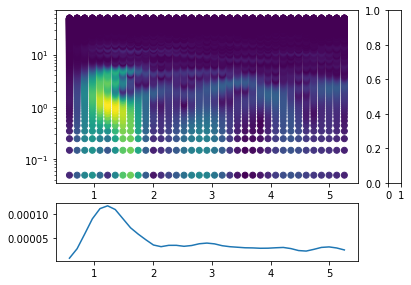

In [161]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.37, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.87, 0.37, 0.03, 0.6])
ax2.scatter(x,y, c = amp, cmap='viridis')
ax2.set_yscale('log')
ax1.plot(x[0:37], sum(columns_amp, 1))

[0.57499999999999996,
 0.70500000000000007,
 0.83499999999999996,
 0.96500000000000008,
 1.095,
 1.2250000000000001,
 1.355,
 1.4850000000000001,
 1.615,
 1.7450000000000001,
 1.875,
 2.0049999999999999,
 2.1350000000000002,
 2.2650000000000001,
 2.395,
 2.5249999999999999,
 2.6550000000000002,
 2.7850000000000001,
 2.915,
 3.0449999999999999,
 3.1750000000000003,
 3.3050000000000002,
 3.4350000000000001,
 3.5649999999999999,
 3.6949999999999998,
 3.8250000000000002,
 3.9549999999999996,
 4.085,
 4.2149999999999999,
 4.3449999999999998,
 4.4749999999999996,
 4.6049999999999995,
 4.7349999999999994,
 4.8649999999999993,
 4.9949999999999992,
 5.125,
 5.2549999999999999]

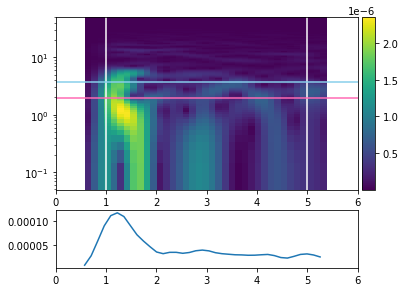

In [166]:
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.2]) #[left bottom width height]
ax2 = fig.add_axes([0.1, 0.37, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.81, 0.37, 0.03, 0.6])
                #make time vector
t = np.arange(d.stats.npts) / d.stats.sampling_rate

#plot waveform    
#ax1.plot(t, d.data, 'k')
ax1.plot(x[0:37], sum(columns_amp, 1))

#plot spectrogram 
spl2 = d
fig = spl2.spectrogram(show=False, axes=ax2, log = True)
mappable = ax2.collections[0]
ax2.vlines(1, 0, 50, color='white')
ax2.vlines(5, 0, 50, color='white')
ax2.hlines(1/tpmax, 0, 6, color='hotpink')
ax2.hlines(1/tc, 0, 6, color='skyblue')
plt.colorbar(mappable=mappable, cax=ax3)





20190131_194949.a
20190131_130953.a
20190131_130350.a
20190131_101656.a
20190131_085520.a


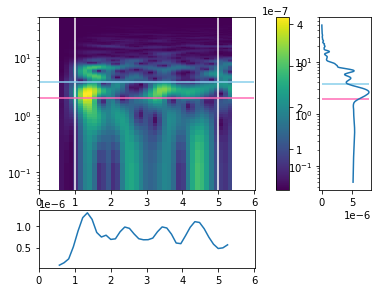

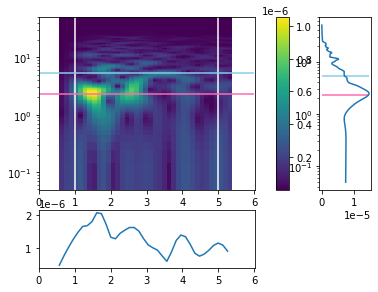

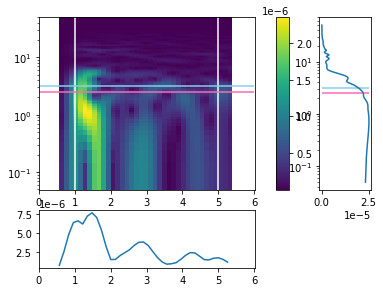

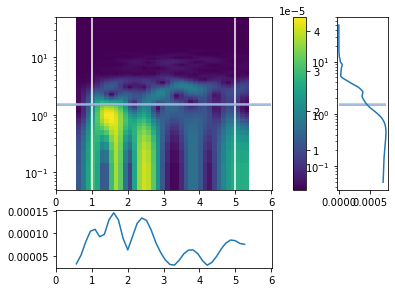

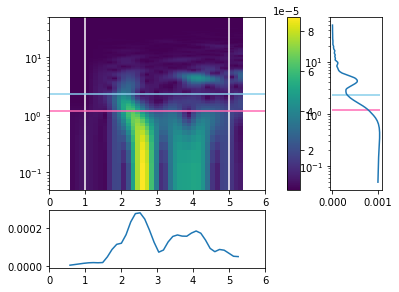

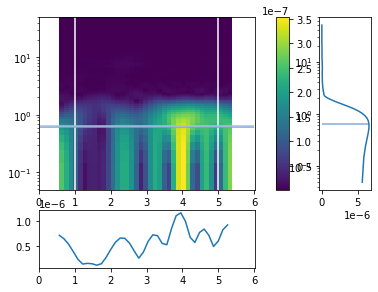

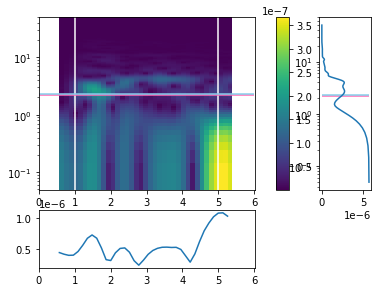

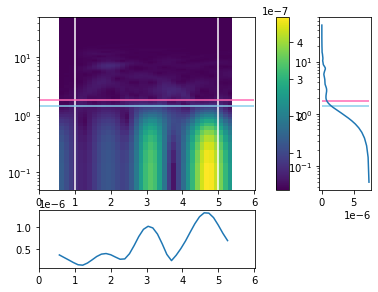

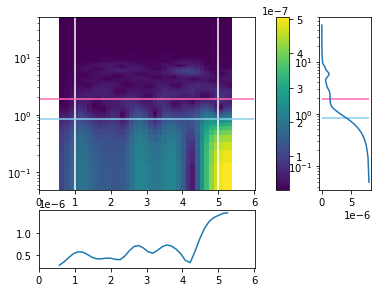

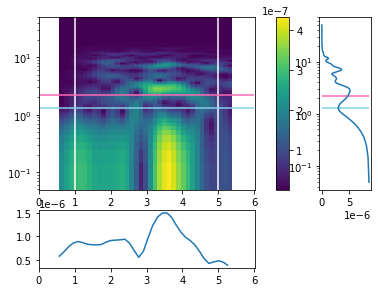

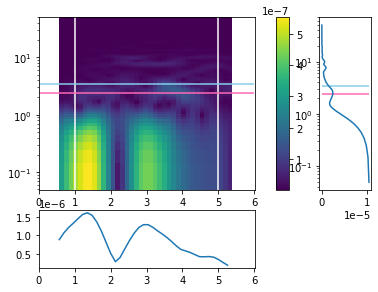

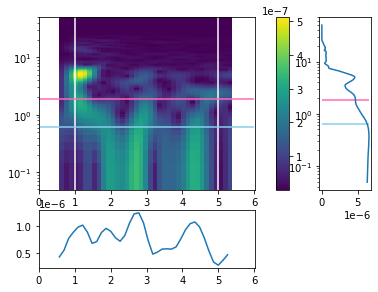

In [13]:
import random 
from datetime import timedelta
for count in range(0, 5):#len(eq_with_data[0:100])):
    eq_no = count #random.randrange(0,len(eq_with_data))
    eq_name = eq_with_data[eq_no]
    Z_comp = 0
    print(eq_name)
    try:
        data = obspy.read(root+eq_name+'/data/*/*')
        #data.plot()
        inv = obspy.read_inventory(root+eq_name+'/station_xml_files/*')
        data.remove_response(inv)
        with open(root+eq_name+'/picks.pkl', 'rb') as f:
            picks = pickle.load(f)
        df_row = df.loc[eq_name]
    except: 
        print('first except')
        continue
    if len(data)>0:
        successful = 0
        for tr_no in range(0, len(data)):
            sr = data[tr_no].stats.sampling_rate
            tr_name = data[tr_no].stats.network+'.'+data[tr_no].stats.station+'.'+data[tr_no].stats.location
            #print(tr_name)
            # only consider vertical stations (Z)
            if data[tr_no].stats.channel[-1] == 'Z':
                try:
                    tpmax = df_row.tpmax[Z_comp]
                    tc = df_row.tc[Z_comp]

                    t = util.filenameToDate(eq_name)
                    filter_start = str(UTCDateTime(t-timedelta(seconds=1)))
                    filter_stop = str(UTCDateTime(t+timedelta(seconds=1)))

                    event = cat.filter('time > ' + filter_start, 'time < ' + filter_stop)
                    # print(event)
                    data_nearby = util.find_nearby_data(data, inv, event[0], 100)
                    #print('pick')
                    pick = UTCDateTime(picks[tr_name])
                    start = pick -1 #int((pick - data[tr_no].stats.starttime)*sr)
                    end = pick + 5 # int(start + 4 * sr)
                    #print('d')
                    d = data[tr_no].copy()#.filter('lowpass', freq=10)
                    d.interpolate(100, 'lanczos', a = 20)
                    d.filter('highpass', freq=0.25) #anything less than 0.25s (1/4s) we can't undertand or model, could be aliased.
                    d.detrend()
                    d.integrate()
                    d.detrend()
                    d.trim(start, end)
                    d.detrend()
                    #print('plotting')

                    from obspy.imaging.spectrogram import spectrogram
                    fig = plt.figure()
                    ax1 = fig.add_axes([0.1, 0.1, 0.5, 0.2]) #[left bottom width height]
                    ax2 = fig.add_axes([0.1, 0.37, 0.5, 0.60], sharex=ax1)
                    ax3 = fig.add_axes([0.65, 0.37, 0.03, 0.6])
                    #ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.2]) #[left bottom width height]
                    #ax2 = fig.add_axes([0.1, 0.37, 0.7, 0.60], sharex=ax1)
                    #ax3 = fig.add_axes([0.81, 0.37, 0.03, 0.6])
                    ax4 = fig.add_axes([0.75, 0.37, 0.12, 0.6])
                                    #make time vector
                    t = np.arange(d.stats.npts) / d.stats.sampling_rate

                    #plot waveform    
                    #ax1.plot(t, d.data, 'k')


                    #plot spectrogram 
                    spl2 = d
                    fig = spl2.spectrogram(show=False, axes=ax2, log = True)
                    mappable = ax2.collections[0]
                    ax2.vlines(1, 0, 50, color='white')
                    ax2.vlines(5, 0, 50, color='white')
                    ax2.hlines(1/tpmax, 0, 6, color='hotpink')
                    ax2.hlines(1/tc, 0, 6, color='skyblue')

                    l = ax2.collections
                    coords = l[0]._coordinates
                    amp = l[0]._A

                    coords_concat = np.array(coords[0][:-1])
                    coords_concat_all = np.array(coords[0][:-1])
                    for i in range(1, len(coords)-1):
                        coords_concat = np.concatenate((coords_concat, coords[i][:-1]))
                    for i in range(1, len(coords)):
                        coords_concat_all = np.concatenate((coords_concat_all, coords[i][:-1]))
                    y = []
                    x = []
                    for j in coords_concat:
                        y.append(j[1])
                        x.append(j[0])
                    y_all = []
                    x_all = []
                    for j in coords_concat_all:
                        y_all.append(j[1])
                        x_all.append(j[0])

                    columns_x = [[] for _ in range(37)]
                    columns_y = [[] for _ in range(37)]
                    columns_amp = [[] for _ in range(37)]
                    columns_y_all = [[] for _ in range(37)]
                    for i in range(0, len(coords_concat)):
                        columns_x[i%37].append(x[i])
                        columns_y[i%37].append(y[i])
                        columns_amp[i%37].append(amp[i])
                    for i in range(0, len(coords_concat_all)):
                        columns_y_all[i%37].append(y_all[i])

                    heights = []
                    for i in range(1, len(columns_y_all[0])):
                        heights.append(log(columns_y_all[0][i])-log(columns_y_all[0][i-1]))

                    rows_x = [[] for _ in range(512)]
                    rows_y = [[] for _ in range(512)]
                    rows_amp = [[] for _ in range(512)]

                    for i in range(0, len(coords_concat)):
                        #print(i)
                        rows_x[i//37].append(x[i])
                        rows_y[i//37].append(y[i])
                        rows_amp[i//37].append(amp[i])

                    ax1.plot(x[0:37], sum(np.array(columns_amp)*np.array(heights), 1))
                    ax4.plot(sum(np.array(rows_amp),1), columns_y[0])
                    ax4.hlines(1/tpmax, 0, max(sum(np.array(rows_amp),1)), color='hotpink')
                    ax4.hlines(1/tc, 0, max(sum(np.array(rows_amp),1)), color='skyblue')
                    ax4.set_yscale('log')

                    #ax1.plot(x[0:37], sum(np.array(columns_amp)*np.array(heights[0:512]), 1))
                    #ax4.scatter(sum(np.array(rows_amp), 1), rows_y)
                    #ax4 = ax1.twinx()
                    #ax4.plot(x[0:37], sum(columns_amp, 1), c = 'tab:orange')

                    plt.colorbar(mappable=mappable, cax=ax3)
                    Z_comp += 1
                except:
                    continue #print('except')
                

In [10]:
np.sum(np.array(rows_amp), 1)

array([  7.15182052e-04,   7.30908985e-04,   7.46461890e-04,
         7.57550680e-04,   7.61662715e-04,   7.57374590e-04,
         7.44126227e-04,   7.22116394e-04,   6.92228343e-04,
         6.55961778e-04,   6.15374261e-04,   5.73253099e-04,
         5.33439169e-04,   5.00955539e-04,   4.73738223e-04,
         4.50739095e-04,   4.32899851e-04,   4.19156192e-04,
         4.07106932e-04,   3.95668622e-04,   3.85007403e-04,
         3.77634133e-04,   3.75107634e-04,   3.79264573e-04,
         3.84293870e-04,   3.87221910e-04,   3.86878174e-04,
         3.82673941e-04,   3.74544169e-04,   3.62949052e-04,
         3.49333437e-04,   3.36238949e-04,   3.21996488e-04,
         3.05541567e-04,   2.87048638e-04,   2.67169906e-04,
         2.46970220e-04,   2.29229991e-04,   2.13646064e-04,
         1.98338629e-04,   1.83055323e-04,   1.67823863e-04,
         1.53094724e-04,   1.39396621e-04,   1.25808485e-04,
         1.12106282e-04,   9.84346980e-05,   8.50689394e-05,
         7.23707108e-05,

In [35]:
                    columns_x = [[] for _ in range(37)]
                    columns_y = [[] for _ in range(37)]
                    columns_amp = [[] for _ in range(37)]

                    for i in range(0, len(coords_concat)):
                        columns_x[i%37].append(x[i])
                        columns_y[i%37].append(y[i])
                        columns_amp[i%37].append(amp[i])
                    
                    rows_x = [[] for _ in range(512)]
                    rows_y = [[] for _ in range(512)]
                    rows_amp = [[] for _ in range(512)]

                    for i in range(0, len(coords_concat)):
                        #print(i)
                        rows_x[i//37].append(x[i])
                        rows_y[i//37].append(y[i])
                        rows_amp[i//37].append(amp[i])
                        
                    ax1.plot(x[0:37], sum(np.array(columns_amp)*np.array(heights[0:512]), 1))
                    ax4.scatter(sum(np.array(rows_amp),1), columns_y[0])

ValueError: operands could not be broadcast together with shapes (37,512) (511,) 

In [337]:
                    rows_x = [[] for _ in range(512)]
                    rows_y = [[] for _ in range(512)]
                    rows_amp = [[] for _ in range(512)]

                    for i in range(0, len(coords_concat)):
                        #print(i)
                        rows_x[i//37].append(x[i])
                        rows_y[i//37].append(y[i])
                        rows_amp[i//37].append(amp[i])

In [341]:
columns_y

[[0.048828125,
  0.146484375,
  0.244140625,
  0.341796875,
  0.439453125,
  0.537109375,
  0.634765625,
  0.732421875,
  0.830078125,
  0.927734375,
  1.025390625,
  1.123046875,
  1.220703125,
  1.318359375,
  1.416015625,
  1.513671875,
  1.611328125,
  1.708984375,
  1.806640625,
  1.904296875,
  2.001953125,
  2.099609375,
  2.197265625,
  2.294921875,
  2.392578125,
  2.490234375,
  2.587890625,
  2.685546875,
  2.783203125,
  2.880859375,
  2.978515625,
  3.076171875,
  3.173828125,
  3.271484375,
  3.369140625,
  3.466796875,
  3.564453125,
  3.662109375,
  3.759765625,
  3.857421875,
  3.955078125,
  4.052734375,
  4.150390625,
  4.248046875,
  4.345703125,
  4.443359375,
  4.541015625,
  4.638671875,
  4.736328125,
  4.833984375,
  4.931640625,
  5.029296875,
  5.126953125,
  5.224609375,
  5.322265625,
  5.419921875,
  5.517578125,
  5.615234375,
  5.712890625,
  5.810546875,
  5.908203125,
  6.005859375,
  6.103515625,
  6.201171875,
  6.298828125,
  6.396484375,
  6.494140

In [323]:
for i in range(0, len(coords_concat)):
    if coords_concat[i][1]==coords_concat[0][1]:
        print(i)
        print(coords_concat[i])

0
[ 0.575       0.04882812]
1
[ 0.705       0.04882812]
2
[ 0.835       0.04882812]
3
[ 0.965       0.04882812]
4
[ 1.095       0.04882812]
5
[ 1.225       0.04882812]
6
[ 1.355       0.04882812]
7
[ 1.485       0.04882812]
8
[ 1.615       0.04882812]
9
[ 1.745       0.04882812]
10
[ 1.875       0.04882812]
11
[ 2.005       0.04882812]
12
[ 2.135       0.04882812]
13
[ 2.265       0.04882812]
14
[ 2.395       0.04882812]
15
[ 2.525       0.04882812]
16
[ 2.655       0.04882812]
17
[ 2.785       0.04882812]
18
[ 2.915       0.04882812]
19
[ 3.045       0.04882812]
20
[ 3.175       0.04882812]
21
[ 3.305       0.04882812]
22
[ 3.435       0.04882812]
23
[ 3.565       0.04882812]
24
[ 3.695       0.04882812]
25
[ 3.825       0.04882812]
26
[ 3.955       0.04882812]
27
[ 4.085       0.04882812]
28
[ 4.215       0.04882812]
29
[ 4.345       0.04882812]
30
[ 4.475       0.04882812]
31
[ 4.605       0.04882812]
32
[ 4.735       0.04882812]
33
[ 4.865       0.04882812]
34
[ 4.995       0.04882

In [287]:
len(sum(np.array(rows_amp), 1))

512

In [172]:
sum(columns_amp, 1)

array([ 0.00313017,  0.00483483,  0.00656859,  0.00782955,  0.00838215,
        0.00830873,  0.00786844,  0.00750964,  0.0072575 ,  0.00726761,
        0.00774243,  0.00839721,  0.00877483,  0.00857975,  0.00796425,
        0.00718018,  0.00650383,  0.00645615,  0.00714524,  0.00796067,
        0.00849614,  0.00850686,  0.00813139,  0.00790303,  0.00798562,
        0.00850754,  0.00879052,  0.00871986,  0.00845748,  0.00815056,
        0.00818316,  0.00858199,  0.00882845,  0.00864508,  0.00831225,
        0.00804135,  0.00807755])

In [36]:
heights = []
for i in range(1, len(columns_y[0])):
    heights.append(log(columns_y[0][i])-log(columns_y[0][i-1]))

In [37]:
np.array(heights).shape

(511,)

In [47]:
np.array(columns_y_all).shape

(37, 513)

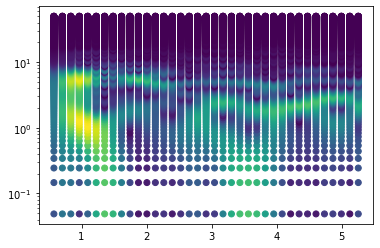

In [194]:
plt.scatter(x,y, c = amp, cmap='viridis')
plt.yscale('log')

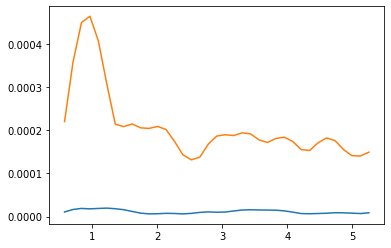

In [235]:
plt.plot(x[0:37], sum(np.array(columns_amp)*np.array(heights[0:512]), 1))
plt.plot(x[0:37], sum(np.array(columns_amp), 1))

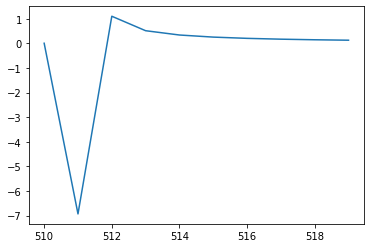

In [214]:
plt.plot(np.arange(510, 520), heights[510:520] )

In [219]:
sum(np.array(columns_amp),1)

array([ 0.00313017,  0.00483483,  0.00656859,  0.00782955,  0.00838215,
        0.00830873,  0.00786844,  0.00750964,  0.0072575 ,  0.00726761,
        0.00774243,  0.00839721,  0.00877483,  0.00857975,  0.00796425,
        0.00718018,  0.00650383,  0.00645615,  0.00714524,  0.00796067,
        0.00849614,  0.00850686,  0.00813139,  0.00790303,  0.00798562,
        0.00850754,  0.00879052,  0.00871986,  0.00845748,  0.00815056,
        0.00818316,  0.00858199,  0.00882845,  0.00864508,  0.00831225,
        0.00804135,  0.00807755])

In [229]:
np.array(columns_amp).shape

(37, 512)

In [225]:
25600/512


50.0